# Setup

## Import packages

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

In [1802]:
def sns_joint_equal_axes(g):
    
    g.ax_joint.set_aspect('equal')
    
    # Get the position of the joint plot and marginal plots
    joint_position = g.ax_joint.get_position()
    xmarg_position = g.ax_marg_x.get_position()
    ymarg_position = g.ax_marg_y.get_position()

    # Set the position and size of the x-axis marginal plot
    g.ax_marg_x.set_position([xmarg_position.x0, joint_position.y1 + 0.02, joint_position.width, xmarg_position.height])

    # Set the position and size of the y-axis marginal plot
    g.ax_marg_y.set_position([ymarg_position.x0, joint_position.y0, ymarg_position.width, joint_position.height])
    
    return g


## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [1126]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

vx_sizes = [16,16,30]

## Load files

In [847]:
dirpath = Path(settings_dict['save_dir'])


In [1840]:
nodefiles = get_cell_filepaths(dirpath)

In [1859]:
df_syn = pd.read_csv(dirpath / 'graphs/df_presyn.csv')
syn = 'pre-synaptic'

if syn == 'pre-synaptic':
    df_syn.drop(df_syn[df_syn['pre'].isin([299392199,386392158,472361842,389085521,227254070,228321391,403522169,313068329,126649726])].index, inplace=True)


## Cell types dict

In [1860]:
cell_types = {}

for i,r in df_syn.iterrows():
    cell_types[r['pre']]=r['pre_type']
    cell_types[r['post']]=r['post_type']
    


## Cell features to add

### Soma diameter

In [1889]:
cells_in_synmat = set(df_syn['pre'].unique())|set(df_syn['post'].unique())

soma_diam = {}
soma_loc = {}
for x in cells_in_synmat:
    cell = ecrest(settings_dict,filepath = nodefiles[str(x)],launch_viewer=False)
    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']

        if len(soma_anno)==4:
            xpts = [p[0] for p in soma_anno]
            ypts = [p[1] for p in soma_anno]
            zpts = [p[2] for p in soma_anno]
            
            soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))),int((np.max(zpts)-np.min(zpts)))])/1000
            soma_loc[x] = (np.mean([np.max(xpts),np.min(xpts)])/1000,np.mean(ypts)/1000,np.mean([np.max(zpts),np.min(zpts)])/1000)
            
        if len(soma_anno)!=4:
            soma_diam[x] = np.NaN
            soma_loc[x] = np.NaN
    
    if 'soma' not in cell.cell_data['end_points'].keys():
        soma_diam[x] = np.NaN
        soma_loc[x] = np.NaN


In [1891]:
soma_diam[127672247]

KeyError: 127672247

#### distribution soma diam

In [1498]:
df = pd.DataFrame(soma_diam.items(), columns=['cell', 'soma diam']).set_index('cell')

for c in df.index:
    df.loc[c,'type'] = cell_types[c]

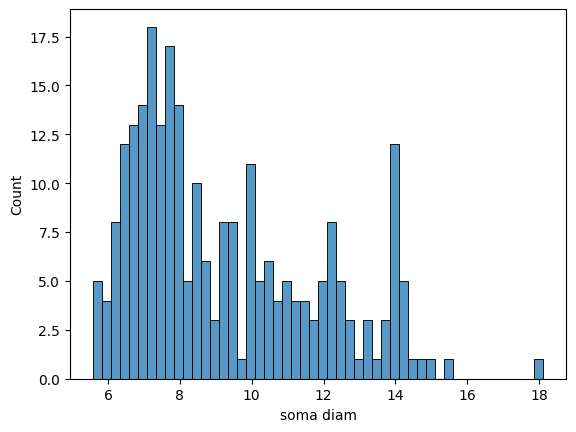

In [1499]:
# df['binned'] = pd.cut(df['soma diam'], bins=np.arange(0,4000,200)).values
ax = sns.histplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2'])],x='soma diam',bins = 50)#,hue='type')

<AxesSubplot:xlabel='soma diam', ylabel='Density'>

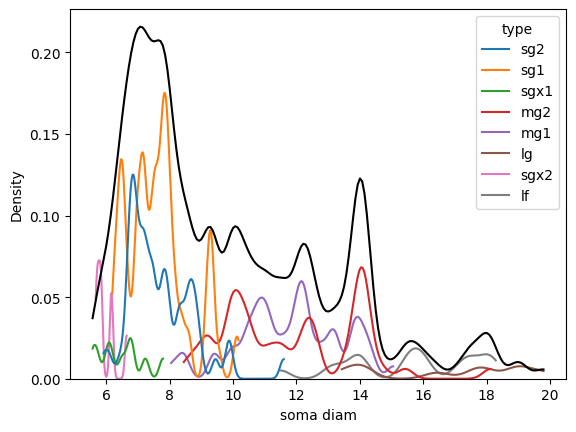

In [1500]:

hfig,ax = plt.subplots(1)
sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2','lg','lf'])],x='soma diam',bw_adjust=0.25,cut=0,hue='type',ax=ax)
sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2','lg','lf'])],x='soma diam',bw_adjust=0.25,cut=0,color='black',ax=ax)

#### Load into df_syn

In [1554]:

for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_diam']=soma_diam[df_syn.loc[i,'pre']]
        df_syn.loc[i,'post_diam']=soma_diam[df_syn.loc[i,'post']]
    except:
        continue
df_syn.loc[:,'diam_diff'] = (df_syn['post_diam']-df_syn['pre_diam'])/df_syn['pre_diam']


# Completeness of synapses

In [1863]:
all_types = set(df_syn['pre_type'].unique()) | set(df_syn['post_type'].unique()) #- set(['glia'])
c_type_check = all_types #['mg1','mg2','sg1','sg2','grc']

df_progress = pd.DataFrame(columns = ['id','type','soma-diam','n_syn','done','todo','completed'])
for c in df_syn['pre'].unique():
    
    if (df_syn[df_syn['pre'] == c]['pre_type'].unique()[0] in c_type_check):

        c_df = df_syn[df_syn['pre'].isin([c])]

        cell = ecrest(settings_dict,filepath = nodefiles[str(c)],launch_viewer=False)

        cell_dict = {
            'id': cell.cell_data['metadata']['main_seg']['base'],
            'type': cell_types[c], #cell.get_ctype("manual"),
            'soma-diam': soma_diam[c],
            'n_syn': len(cell.cell_data['end_points'][syn]),
            'done': len(c_df),
            'todo': len(cell.cell_data['end_points'][syn]) - len(c_df),
            'completed': len(c_df) / (len(cell.cell_data['end_points'][syn]))
            }

        df_progress = pd.concat([df_progress,pd.DataFrame([cell_dict])])

In [1042]:
# df_progress[df_progress['type'].isin(['mg1'])].sort_values('todo')

In [1844]:
# df_progress[df_progress['completed']>0.9]

# Edges

## Filtered df_syn

In [1864]:
# Filter by pre and/or post cell type

network_types = (set(df_syn['pre_type'].unique()) | set(df_syn['post_type'].unique())) - set(['glia','uk','fov','tsd','dml']) #'tsd','dml','sgx1','sgx2'])
df_syn = df_syn[(df_syn['pre_type'].isin(network_types - set(['sgx1','sgx2'])))&(df_syn['post_type'].isin(network_types))] #- set(['lg','lf'])

In [1865]:
# Filter by completeness of synaptic reconstructions

if syn=='post-synaptic':
    df_syn_completed = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.9]['id'].values])]
    df_syn = pd.concat([df_syn_completed,df_syn[df_syn['pre_type'].isin(['aff'])]])
    
    
if syn=='pre-synaptic':
    df_syn = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.3]['id'].values])]


### synapses locations relative to cell type soma in df_edges

In [1534]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373' 
}

In [1839]:
df_syn

,pre,post,pre_type,post_type
37,127672247,647640784,sg2,lg
38,127672247,647640784,sg2,lg
39,127672247,472392041,sg2,lg
40,127672247,472392041,sg2,lg
41,127672247,472392041,sg2,lg
...,...,...,...,...
9302,61319896,484881347,aff,grc-d
9303,61319896,481520358,aff,grc-d
9304,61319896,310839225,aff,grc-d
9305,61319896,483704550,aff,grc-d


In [1856]:
df_loc = pd.DataFrame(soma_loc.items(), columns=['cell', 'soma loc']).set_index('cell')
post_types_subset = ['lf','lg']

for c in df_loc.index:
    df_loc.loc[c,'type'] = cell_types[c]

# df_to_plot = df_loc[(df_loc.index.isin(df_progress[df_progress['completed']>0.9]['id'].values))&df_loc['type'].isin(['mg1','mg2','sg1','sg2'])].dropna()
df_to_plot = df_loc[df_loc['type'].isin(['mg1','mg2','sg1','sg2'])].dropna()

# Initialize an empty DataFrame
df_syn_locs = pd.DataFrame(columns=['x', 'y', 'z', 'cell_type'])

# Loop through cell types and extend the DataFrame
for i,r in df_to_plot.iterrows():
    # print(i,r)
    
    x,y,z = r['soma loc']
    cell = df_syn[(df_syn['pre'].isin([int(i)])) & (df_syn['post_type'].isin(post_types_subset))]
    # cell = ecrest(settings_dict,filepath = nodefiles[i],launch_viewer=False)
    positions = [(s[0]/1000-x,s[1]/1000-y,s[2]/1000-z) for s in list(cell[['x','y','z']].to_records(index=False))]#cell.cell_data['end_points']['post-synaptic']]
   
    # break
    cell_df = pd.DataFrame(positions, columns=['x', 'y', 'z'])  # Create DataFrame for the current cell type
    cell_df['cell_type'] = r['type']  # Add cell type column
    df_syn_locs = pd.concat([df_syn_locs, cell_df], ignore_index=True)  # Concatenate the current cell DataFrame to the main DataFrame

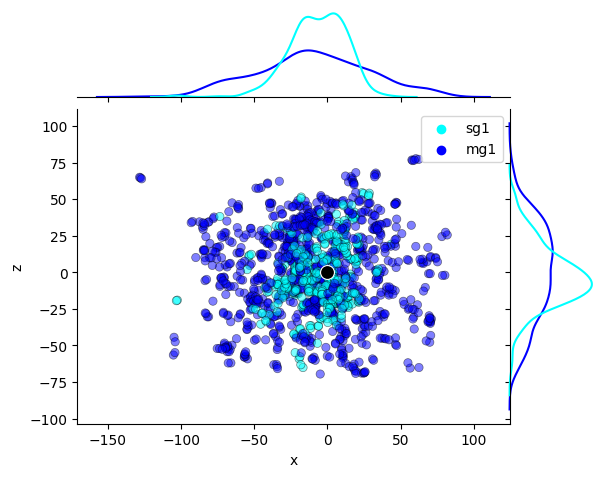

In [1850]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','mg1'])], 
                  x="x", y="z", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), space=0)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);

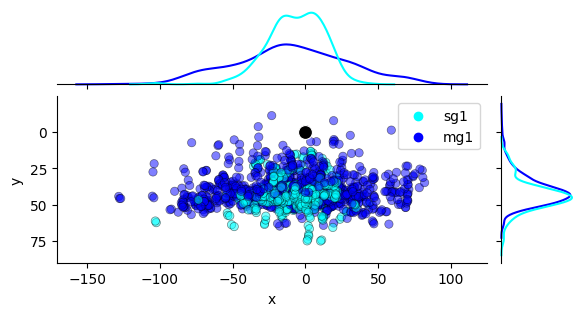

In [1857]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','mg1'])], 
                  x="x", y="y", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), ratio=5)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

g.ax_joint.invert_yaxis()

g = sns_joint_equal_axes(g)

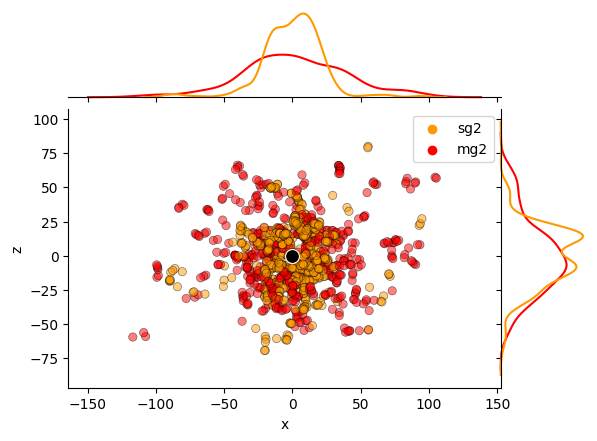

In [1806]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2','mg2'])], 
                  x="x", y="z", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), space=0)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);

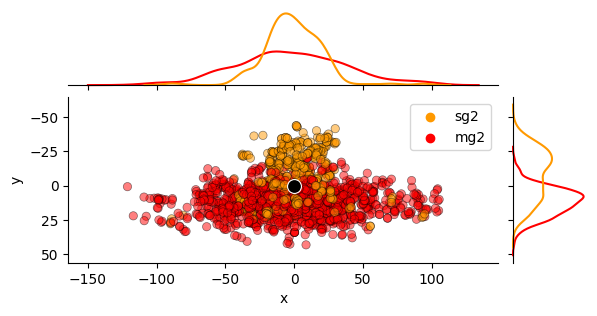

In [1858]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2','mg2'])], 
                  x="x", y="y", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), ratio=5)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

g.ax_joint.invert_yaxis()

g = sns_joint_equal_axes(g)

In [ ]:
g.ax_joint.set_aspect('equal')

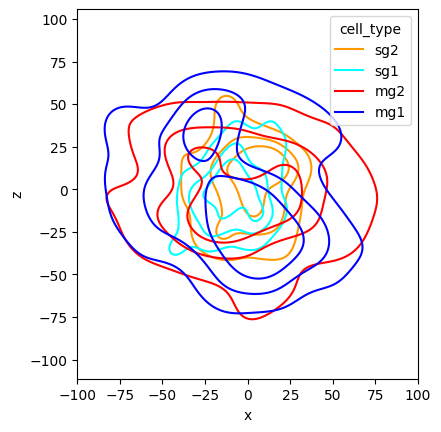

In [1853]:
# hfig,ax = plt.subplots(1,figsize=(3,6))
g = sns.kdeplot(data = df_syn_locs,x='x',y='z',hue='cell_type',common_norm=False,palette=syn_colors,levels=4,thresh=0.15)#,fill=True,alpha = 0.25)

ax = plt.gca()
ax.set_xlim(-100,100)
ax.set_aspect('equal')

# hfig,ax = plt.subplots(3,figsize=(6,6))
# sns.kdeplot(ax=ax[0],data = df_syn_locs,x='x',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# sns.kdeplot(ax=ax[1],data = df_syn_locs,x='y',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# sns.kdeplot(ax=ax[2],data = df_syn_locs,x='z',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# plt.tight_layout()

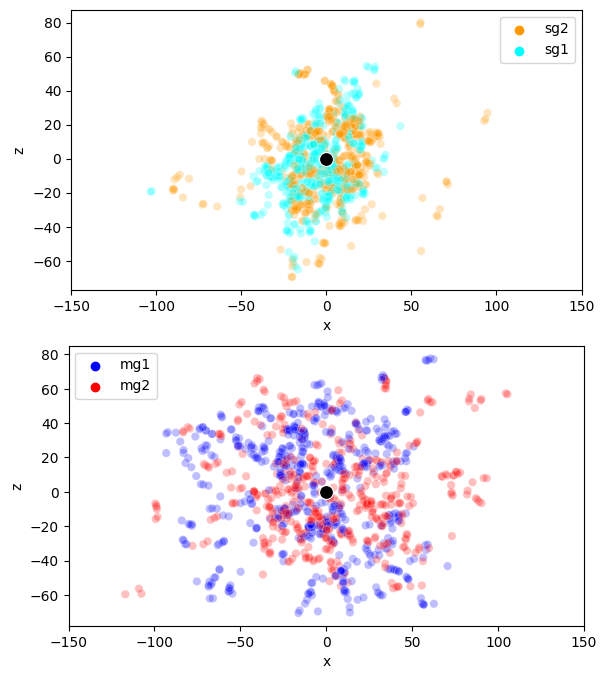

In [1576]:
hfig,ax = plt.subplots(2,figsize=(10,8))
sns.scatterplot(ax=ax[0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','sg2'])],
                x = 'x', y='z',alpha = 0.25,hue='cell_type',palette=syn_colors) #,color='black'
sns.scatterplot(ax=ax[0],x=[0],y=[0],color='black',s=100)
sns.scatterplot(ax=ax[1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg1','mg2'])],
                x = 'x', y='z',alpha = 0.25,hue='cell_type',palette=syn_colors) #,color='black'
sns.scatterplot(ax=ax[1],x=[0],y=[0],color='black',s=100)
for a in ax:
    a.set_xlim(-150,150)
    # a.set_ylim(-3000,3000)
    a.set_aspect('equal')

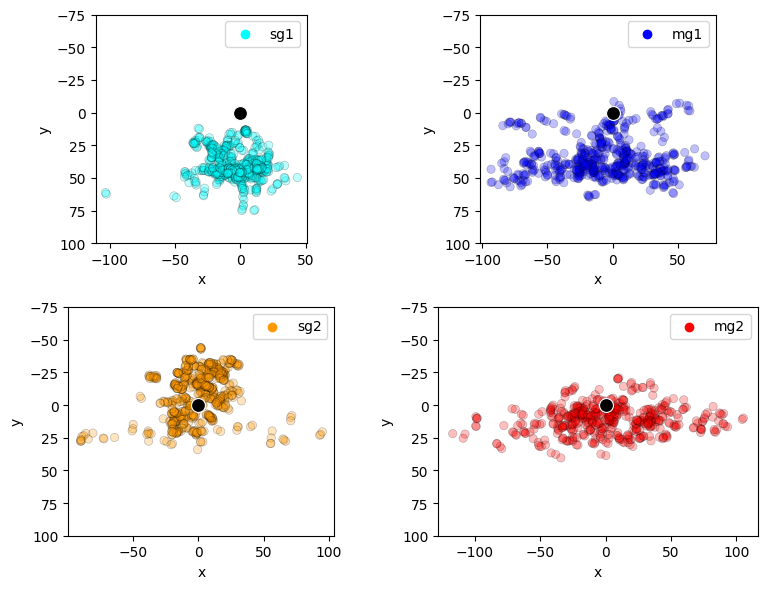

In [1582]:
hfig,ax = plt.subplots(2,2,figsize=(8,6))
sns.scatterplot(ax=ax[0,0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[1,0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[0,1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg1'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[1,1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg2'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
for a in ax:
    for a2 in a:
        sns.scatterplot(ax=a2,x=[0],y=[0],color='black',s=100)

for a in ax:
    for a2 in a:
        # a2.set_xlim(-200,200)
        a2.set_ylim(-75,100)
        a2.set_aspect('equal')
        a2.invert_yaxis()

plt.tight_layout()


## shuffle synaptic connection dataframe

In [ ]:
df1 = df_syn.sample(frac = 1).reset_index()
display(df1)

df_syn.loc[df1['index'],['post']] = df1['post']
df_syn.loc[df1['index'],['post_type']] = df1['post_type']

## df_syn --> df_edges

In [1870]:
# remove structure and soma diameter information if want to

df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1)

In [1871]:
df_edges=df_syn.value_counts().reset_index(name='weight')

# CDF

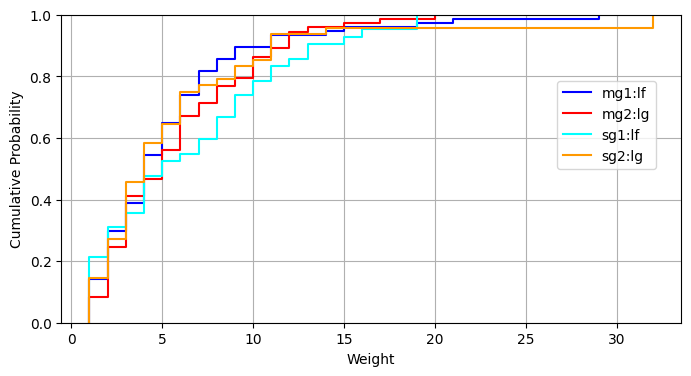

In [1588]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['mg1','sg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'])
    if (pre_type in ['mg2','sg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'])
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

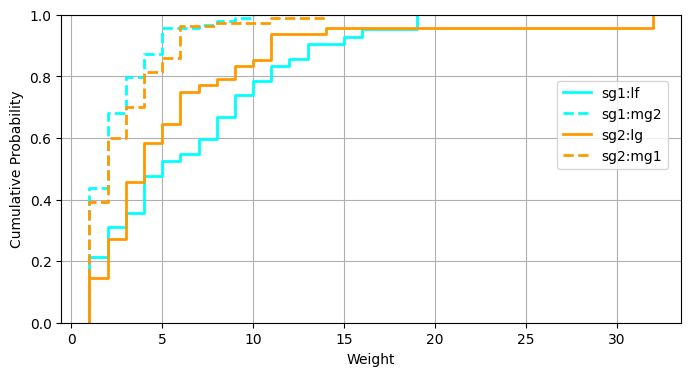

In [1589]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['sg1']) & (post_type in ['mg2']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['sg2']) & (post_type in ['mg1']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['sg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    if (pre_type in ['sg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

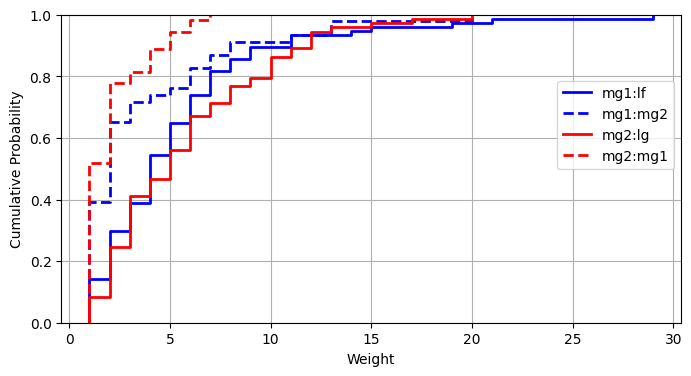

In [1834]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['mg1']) & (post_type in ['mg2']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['mg2']) & (post_type in ['mg1']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['mg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    if (pre_type in ['mg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

# Connectivity Matrix quantifications

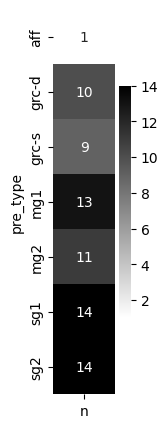

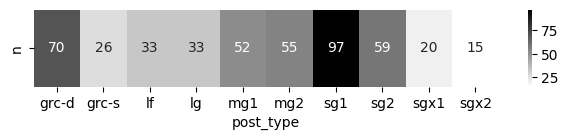

In [1697]:
# Calculate the total number of 'pre' nodes for each 'pre_type'
total_pre_nodes = df_edges.groupby('pre_type')['pre'].nunique().reset_index()
total_pre_nodes.loc[:,'number labeled']='n'
total_pre_nodes = total_pre_nodes.pivot(index='pre_type', columns='number labeled', values='pre')

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_nodes, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

###
# Calculate the total number of 'post' nodes for each 'post_type'
total_post_nodes = df_edges.groupby('post_type')['post'].nunique().reset_index()
total_post_nodes.loc[:,'number reconstructed']='n'
total_post_nodes = total_post_nodes.pivot(index='number reconstructed', columns='post_type', values='post')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_nodes, annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

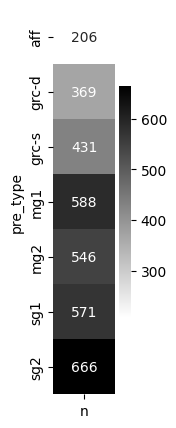

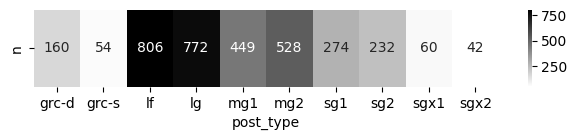

In [1700]:
grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].sum().reset_index()
matrix = grouped.pivot(index='pre_type', columns='post_type', values='weight')#.fillna(0)

### pre
df_pivot = df_edges.groupby('pre_type')['weight'].sum().reset_index()
df_pivot.loc[:,'n']='n'
total_pre_syn = df_pivot.pivot(index='pre_type', columns='n',values='weight')

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_syn, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

### post
df_pivot = df_edges.groupby('post_type')['weight'].sum().reset_index()
df_pivot.loc[:,'n']='n'
total_post_syn = df_pivot.pivot(index='n', columns='post_type',values='weight')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_syn,annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

In [1626]:
total_pre_syn / total_pre_nodes

n,n
pre_type,
aff,206.000000
grc-d,36.900000
grc-s,47.888889
mg1,45.230769
mg2,49.636364
sg1,40.785714
sg2,47.571429


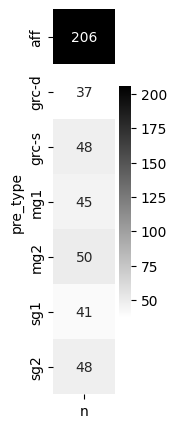

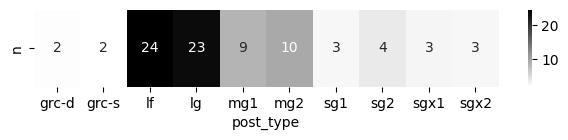

In [1701]:
'''mean synapses per cell'''

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_syn / total_pre_nodes, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_syn / total_post_nodes,annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

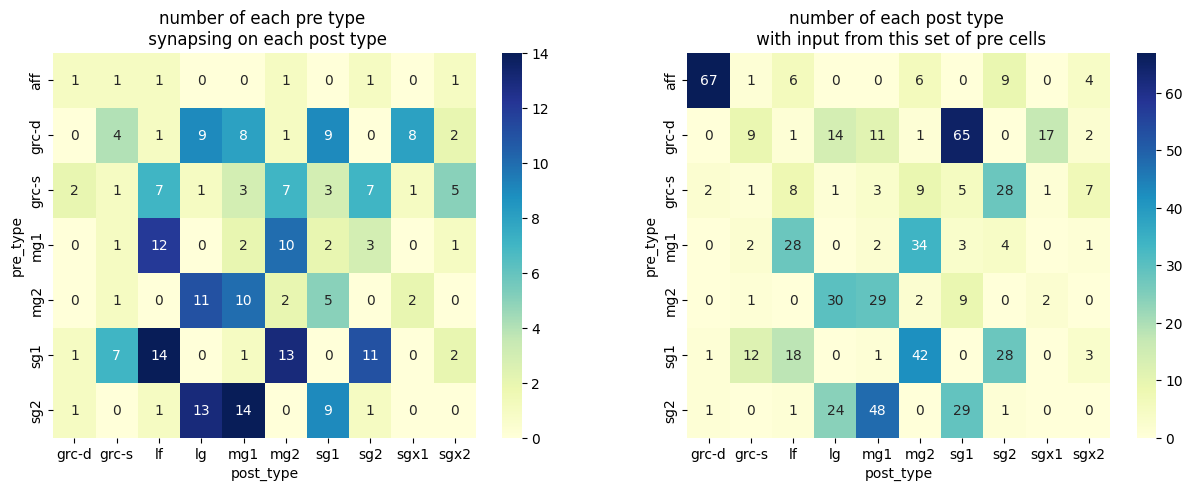

In [1389]:
'''
This code does not repeat counting a post cell if more than one pre cell synapses on it
'''
# Calculate the number of 'pre' nodes of each 'pre_type' for each 'post_type'
pre_type_contributions = df_edges.groupby(['pre_type', 'post_type'])['pre'].nunique().unstack(fill_value=0)

# Calculate the number of 'post' nodes of each 'post_type' for each 'pre_type'
post_type_contributions = df_edges.groupby(['pre_type', 'post_type'])['post'].nunique().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(pre_type_contributions, annot=True, cmap="YlGnBu", ax=axes[0])
sns.heatmap(post_type_contributions, annot=True, cmap="YlGnBu", ax=axes[1])

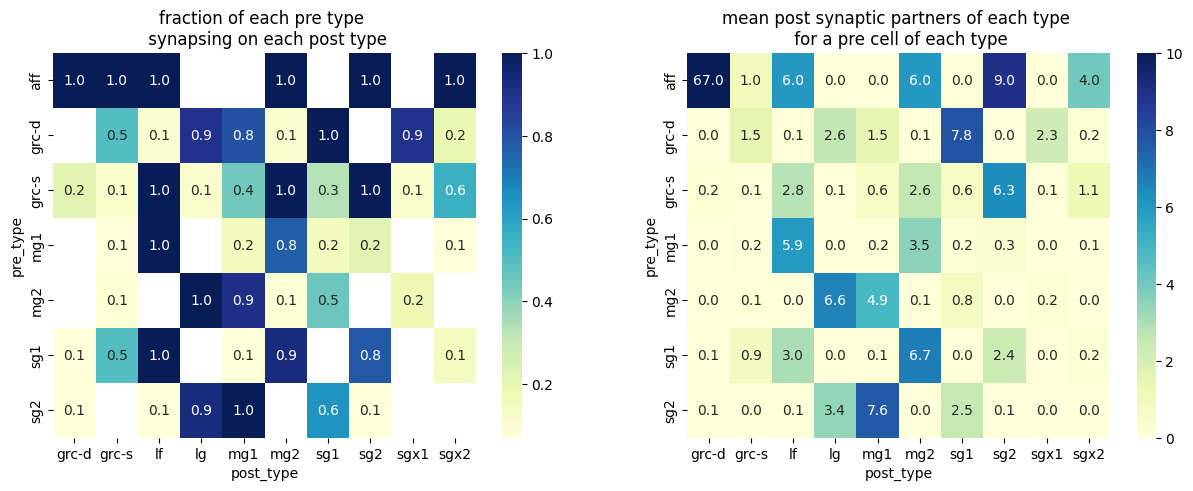

In [1663]:
# Calculate the number of edges for each pre-post pair (unique_counts['n_post'])
# Different from the number of unique post nodes
edge_counts = df_edges.groupby(['pre_type', 'post_type','pre'])[['post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['post'].sum().reset_index().rename(columns={'post': 'n_post'})
# The following gives the same as "pre_type_contributions" but with more code: unique_counts['n_pre'] = df_edges.groupby(['pre_type', 'post_type'])[['pre','post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['pre'].sum().reset_index().rename(columns={'pre': 'n_pre'})['n_pre']
pre_counts = df_edges.groupby(['pre_type', 'post_type'])['pre'].nunique().reset_index().rename(columns={'pre': 'n_pre'})
edge_counts['n_pre'] = pre_counts['n_pre']

n_pre_all = [df_edges.groupby(['pre_type'])['pre'].nunique()[p_] for p_ in unique_counts['pre_type']]

edge_counts['percent_pre'] = edge_counts['n_pre'].div(n_pre_all)
edge_counts['mean_post_count'] = edge_counts['n_post'].div(n_pre_all)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

result_pivot = edge_counts.pivot(index='pre_type', columns='post_type', values='percent_pre')
sns.heatmap(result_pivot, annot=True, fmt=".1f", cmap="YlGnBu", ax = axes[0])

result_pivot = edge_counts.pivot(index='pre_type', columns='post_type', values='mean_post_count').fillna(0)
sns.heatmap(result_pivot, annot=True, fmt=".1f", cmap="YlGnBu", ax = axes[1],vmax=10)

axes[0].set_title('fraction of each pre type \n synapsing on each post type')
axes[1].set_title('mean post synaptic partners of each type \n for a pre cell of each type');

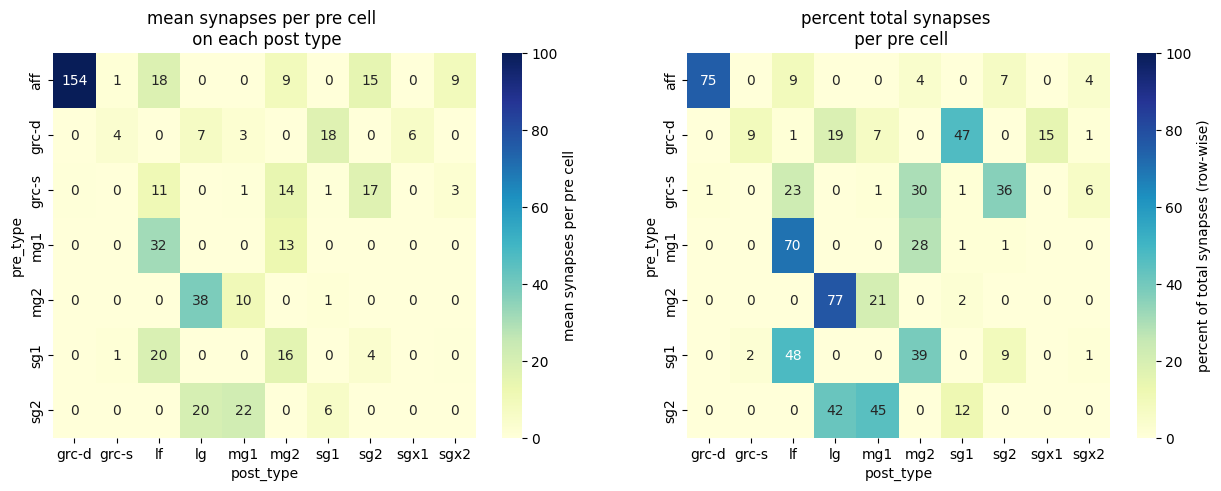

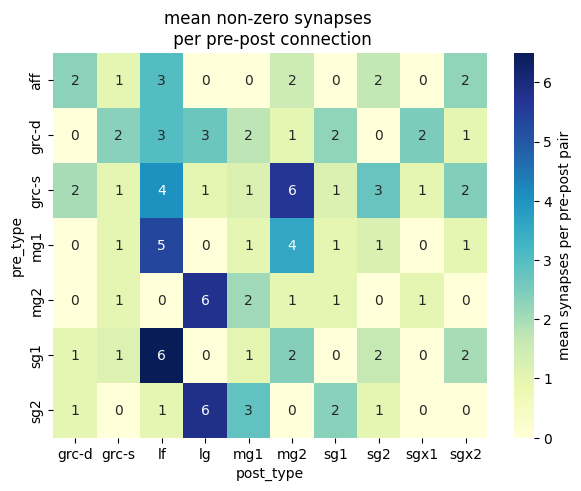

In [1687]:
res = df_edges.groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby('pre_type')['weight'].sum()
n_pre = df_edges.groupby(['pre_type'])['pre'].nunique()#.reset_index()['pre']
n_post = df_edges.groupby(['pre_type'])['post'].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = np.round(res.weight / syn_total *100)
res.loc[:,'weight_per_cell'] = res.weight / n_pre
# res.loc[:,'weight_per_pair'] = res.weight / n_post #* does not work because this is div by all npost, not those in that pairing

# hfig,ax = plt.subplots(1,figsize=(5,2))
fig, axes = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_per_cell').fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,vmax=100,ax=axes[0], fmt=".0f",
           cbar_kws={'label': 'mean synapses per pre cell'})

sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm').fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,vmax=100,ax=axes[1],
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

axes[0].set_title('mean synapses per pre cell \n on each post type')
axes[1].set_title('percent total synapses \n per pre cell');


edge_counts = df_edges.groupby(['pre_type', 'post_type','pre'])[['post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['post'].sum().reset_index().rename(columns={'post': 'n_post'})
res.loc[:,'n_edges']=edge_counts['n_post'].values
res.loc[:,'u_edges']=res['weight']/res['n_edges']
fig, axes = plt.subplots(1, figsize=(7, 5))
sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='u_edges').fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,ax=axes, fmt=".0f",
           cbar_kws={'label': 'mean synapses per pre-post pair'});
axes.set_title('mean non-zero synapses \n per pre-post connection');

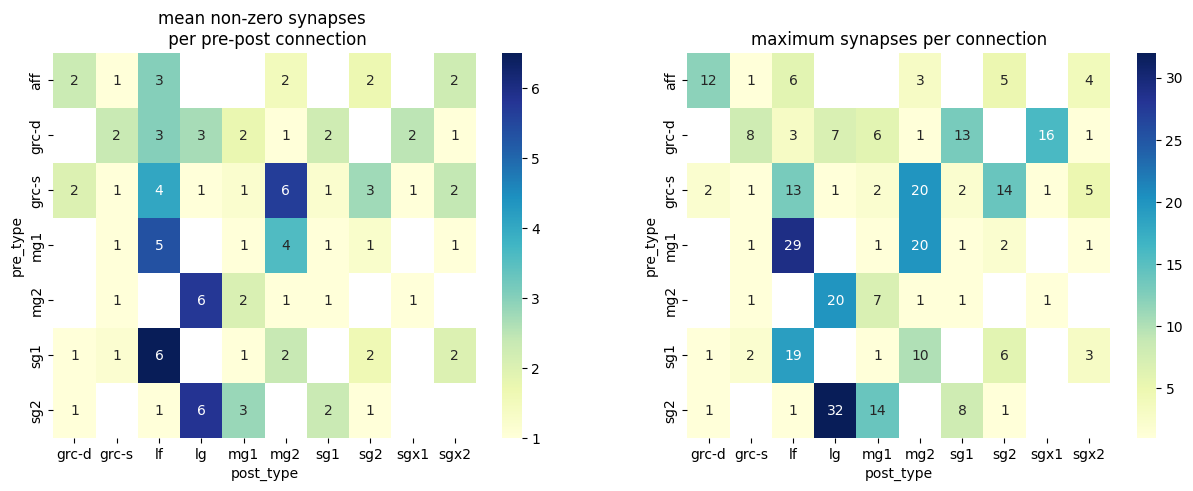

In [1689]:

grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].agg(['mean', 'min', 'max']).reset_index()

# Pivot the DataFrame to get matrices for median, min, and max weights
mean_matrix = grouped.pivot(index='pre_type', columns='post_type', values='mean')
min_matrix = grouped.pivot(index='pre_type', columns='post_type', values='min')
max_matrix = grouped.pivot(index='pre_type', columns='post_type', values='max')

# Create subplots for median, min, and max matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Set titles for subplots
axes[0].set_title('mean non-zero synapses \n per pre-post connection');
# axes[1].set_title('Minimum Connection Weights')
axes[1].set_title('maximum synapses per connection')

# Plot the heatmaps for median, min, and max matrices
sns.heatmap(mean_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[0])
# sns.heatmap(min_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[1])
sns.heatmap(max_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[1])

# plt.tight_layout()
plt.show();

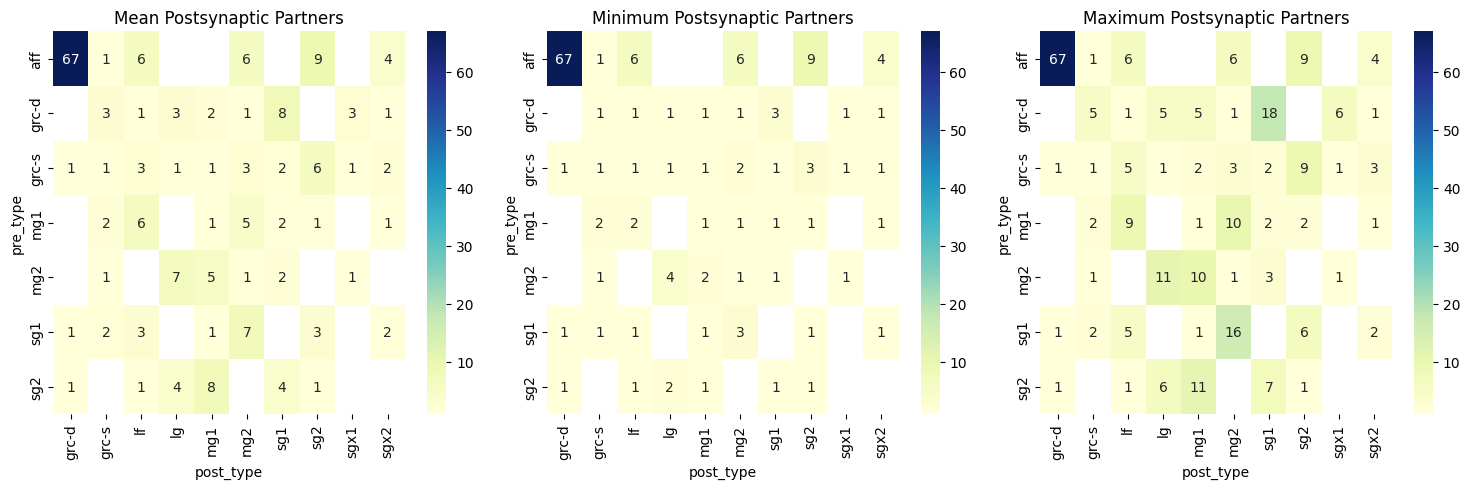

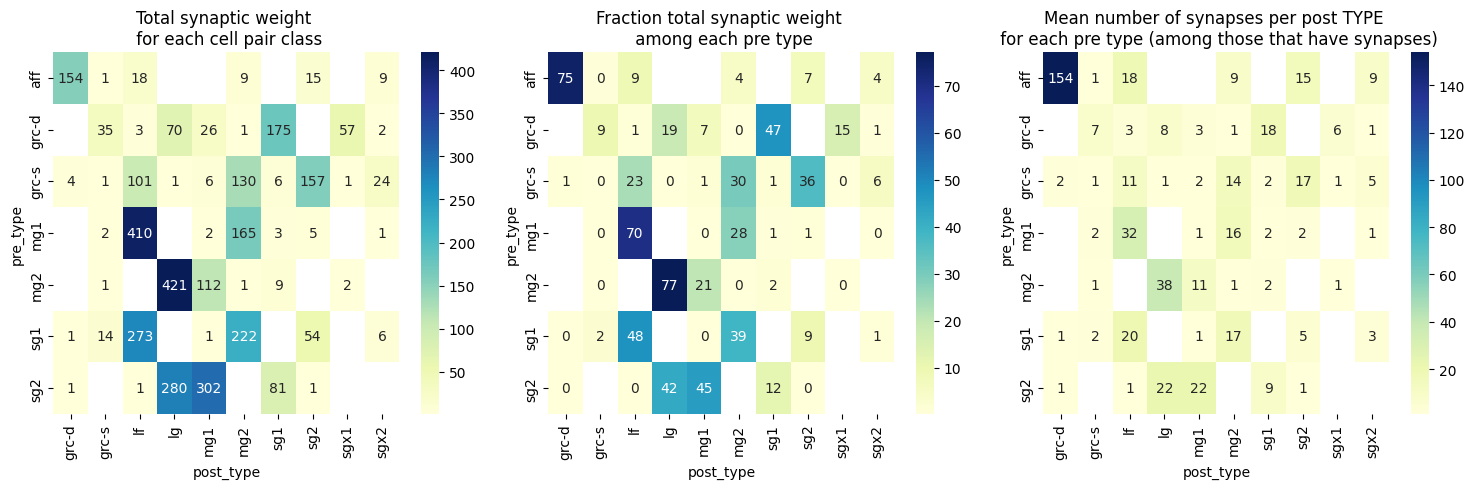

In [1611]:
'''
connection partners only among pre cells that synapse on that type
'''

# Calculate the average number of unique 'post' cells for each 'pre_type'
average_counts = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).mean().unstack() # average_counts = average_counts.applymap(lambda x: f'{x:.1f}').astype(float)
min_counts = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).min().unstack() # min_counts = min_counts.applymap(lambda x: f'{x:.1f}').astype(float)
max_counts = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).max().unstack() # max_counts = max_counts.applymap(lambda x: f'{x:.1f}').astype(float)

# Create subplots for median, min, and max matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Set titles for subplots
axes[0].set_title('Mean Postsynaptic Partners')
axes[1].set_title('Minimum Postsynaptic Partners')
axes[2].set_title('Maximum Postsynaptic Partners')

# Plot the heatmaps for median, min, and max matrices
sns.heatmap(average_counts, annot=True, cmap="YlGnBu", ax=axes[0], fmt=".0f")
sns.heatmap(min_counts, annot=True, cmap="YlGnBu", ax=axes[1], fmt=".0f")
sns.heatmap(max_counts, annot=True, cmap="YlGnBu", ax=axes[2], fmt=".0f")

plt.tight_layout()
# plt.show();

grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].sum().reset_index()

# Pivot the DataFrame to get the desired matrix
matrix = grouped.pivot(index='pre_type', columns='post_type', values='weight')#.fillna(0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(matrix, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[0])

matrix_normalized = matrix.div(matrix.sum(axis=1), axis=0).div(0.01)
sns.heatmap(matrix_normalized, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

average_weight = df_edges.groupby(['pre_type', 'post_type', 'pre'])['weight'].sum().groupby(['pre_type', 'post_type']).mean().unstack() # average_counts = average_counts.applymap(lambda x: f'{x:.1f}').astype(float)
sns.heatmap(average_weight, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[2])

# Set titles for subplots
axes[0].set_title('Total synaptic weight \n for each cell pair class')
axes[1].set_title('Fraction total synaptic weight \n among each pre type')
axes[2].set_title('Mean number of synapses per post TYPE \n for each pre type (among those that have synapses)')

plt.tight_layout();

## As stacked bar

In [1629]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373' 
}

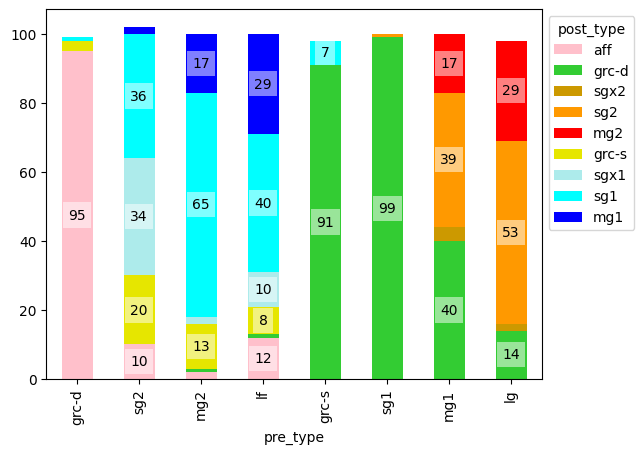

In [1886]:
res = df_edges.groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby('pre_type')['weight'].sum()
n_pre = df_edges.groupby(['pre_type'])['pre'].nunique()#.reset_index()['pre']
n_post = df_edges.groupby(['pre_type'])['post'].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = np.round(res.weight / syn_total *100)

matrix_normalized = res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm').fillna(0)


if syn == 'post-synaptic':
    order_pre = ['aff','grc-d','sg2','mg2','grc-s','sg1','mg1']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['grc-d','sgx2','sg2','mg2','lf','grc-s','sgx1','sg1','mg1','lg']
if syn == 'pre-synaptic':
    order_pre = ['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['aff','grc-d','sgx2','sg2','mg2','grc-s','sgx1','sg1','mg1']

ax = matrix_normalized.loc[order_pre,order_post].plot.bar(stacked=True,color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))

# cluster map

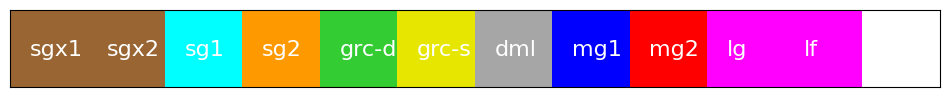

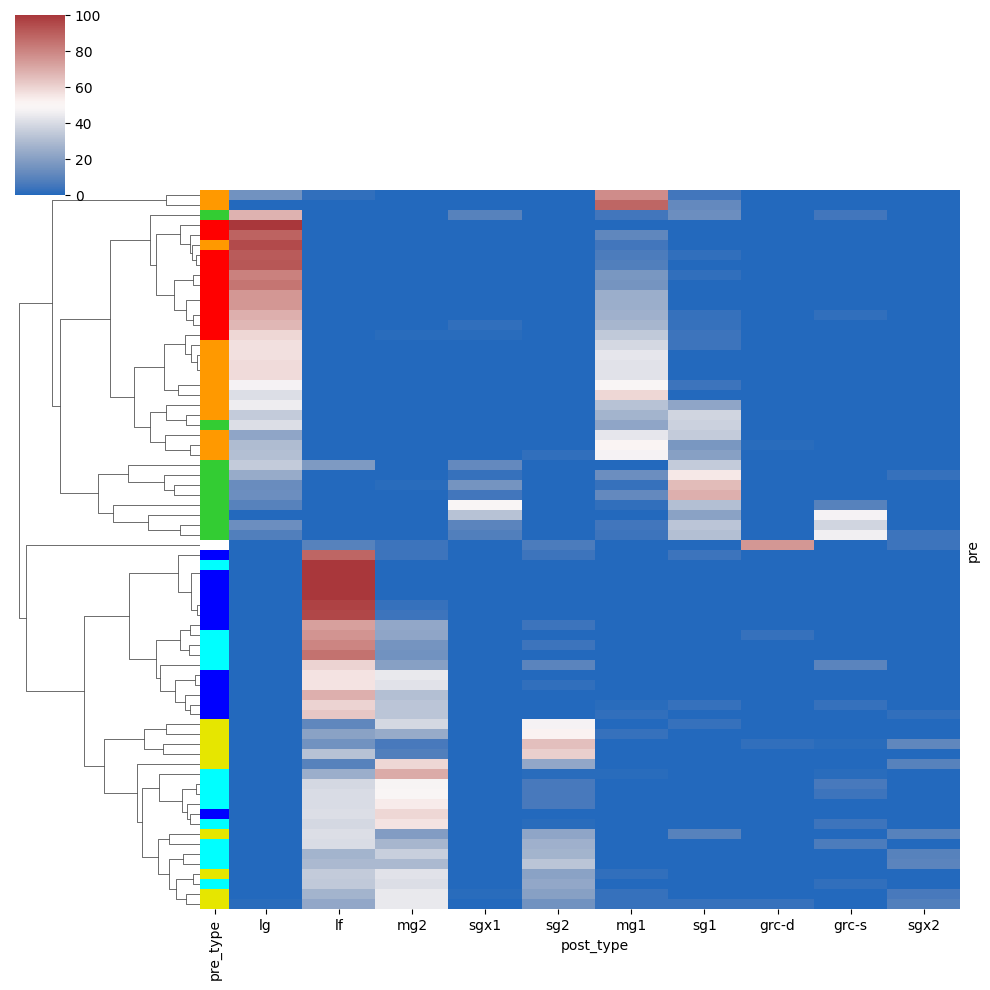

In [1639]:
types_ =  df_edges['pre_type'].unique() # ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s','aff','dml']#
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    # df_grouped = df_edges[df_edges['pre_type']==t].groupby(
    #     ['pre','pre_type','post_type']).count().reset_index().pivot(
    #     index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)

df_map = df_map.set_index('pre')


labels = df_map['pre_type'].unique()
color_pal = sns.color_palette("deep", len(labels))

color_dict = {
    'sgx1':'#996633',
    'sgx2':'#996633',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#a6a6a6',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#ff00ff',
    'lf':'#ff00ff',
    'aff':'#ffffff'
}
sns.palplot(color_dict.values())
ax = plt.gca()
ax.tick_params(left=False, bottom=False)

for i,v in enumerate(color_dict):
    ax.text(i-0.25, 0.1, v,fontsize=16,color='white') 

data_df = df_map[df_edges['post_type'].unique()].div(df_map[df_edges['post_type'].unique()].sum(axis=1),axis=0).mul(100).round(0)
sns.clustermap(data = data_df,
               method='average',
               col_cluster=False, cmap="vlag", center=50,yticklabels=False,
               row_colors = df_map['pre_type'].map(color_dict));

# data_df = df_map[df_edges['post_type'].unique()]
# cmap = sns.color_palette("blend:#d9d9d9,#000000", as_cmap=True)
# cmap.set_under('white')
# sns.clustermap(data = data_df,
#                method='average',
#                col_cluster=False, cmap=cmap, vmin=1, yticklabels=False,
#                row_colors = df_map['pre_type'].map(color_dict));


# The methods are single, complete, average, weighted, ward, median, centroid
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
# default for seaborn is "average"

# Distribution of weights by type

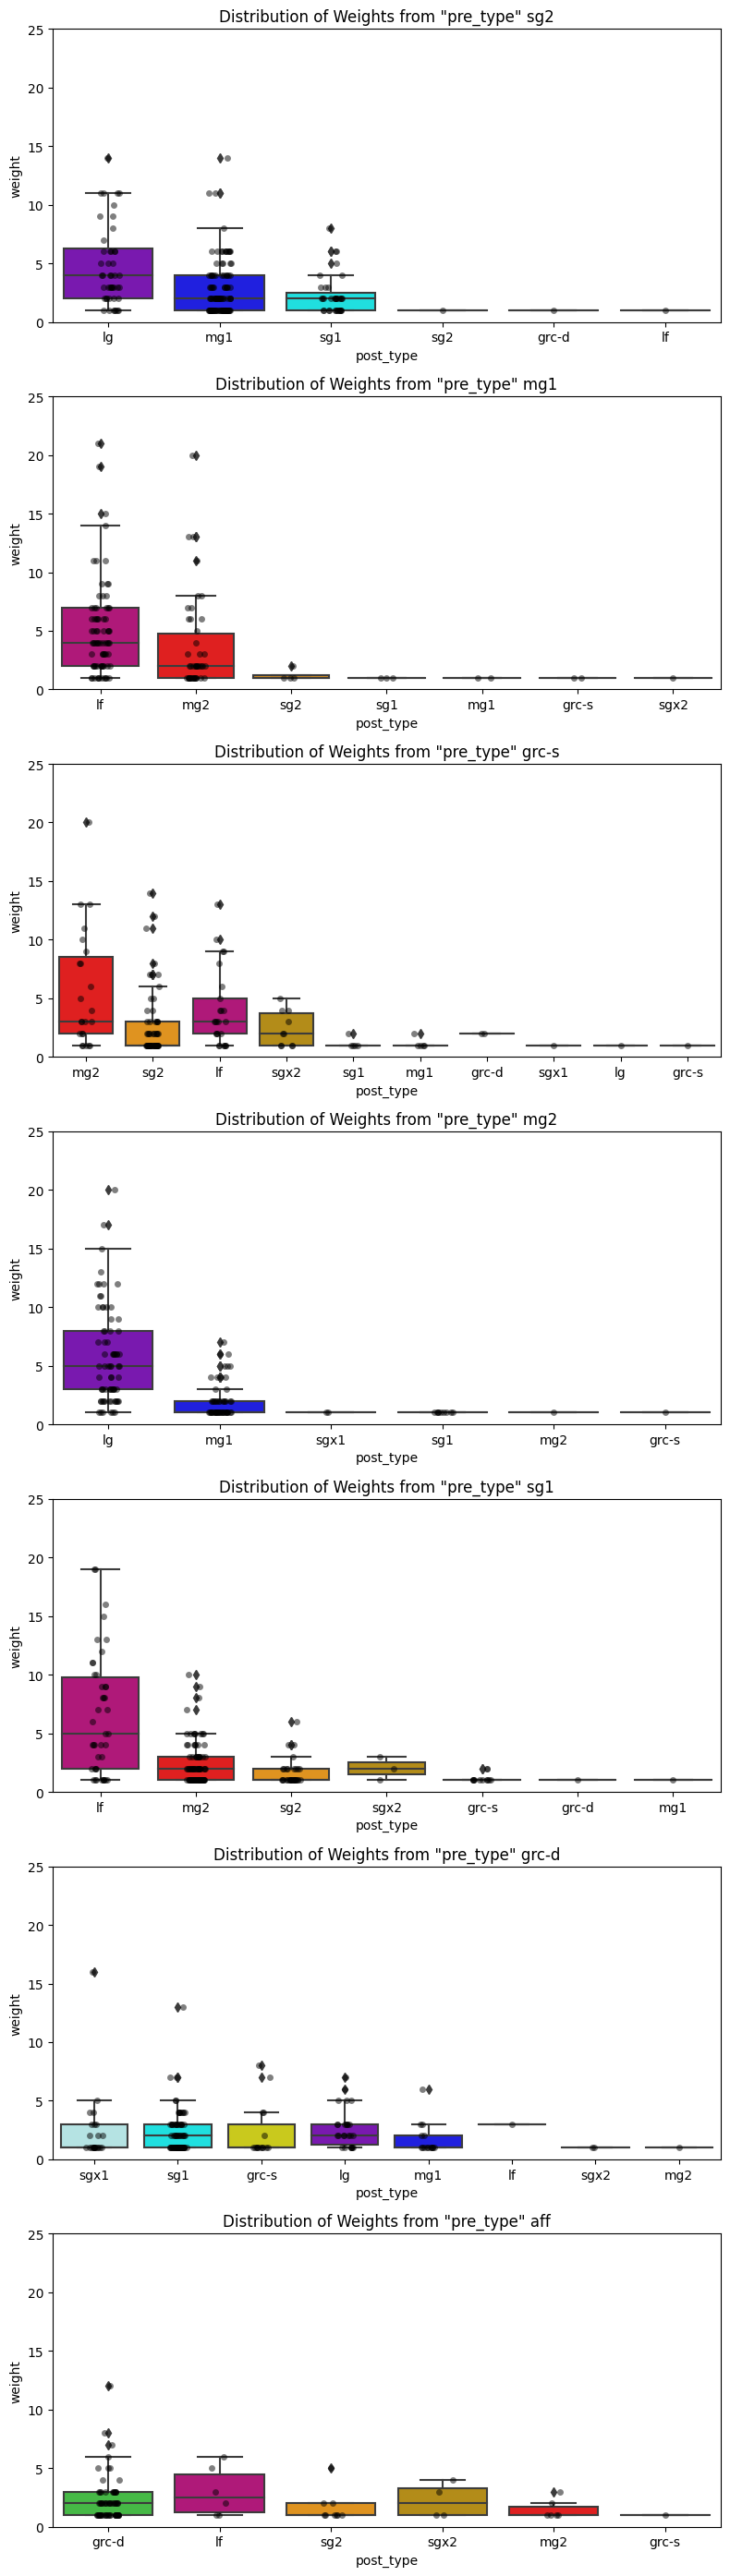

In [1833]:
# df= df_edges[(df_edges['pre_type'].isin(['sg1','sg2','mg1','mg2'])) & (df_edges['post_type'].isin(['mg1','mg2','lf','lg']))]

fig, axes = plt.subplots(len(df_edges['pre_type'].unique()), 1, figsize=(8, 4 * len(df_edges['pre_type'].unique())))

for i,p in enumerate(df_edges['pre_type'].unique()):

    sns.boxplot(data=df_edges[df_edges['pre_type'] == p], x='post_type', y='weight', ax=axes[i],palette=syn_colors)#, inner='quartile', palette='Set2')
    sns.stripplot(data=df_edges[df_edges['pre_type'] == p], x='post_type', y='weight', ax=axes[i],color='black',alpha=0.5)
    axes[i].set_title(f'Distribution of Weights from "pre_type" {p}')
    axes[i].set_ylim(0,25)

plt.tight_layout()
plt.show()